In [7]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import math
import seaborn as sns

TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

(1517, 1815, 3)


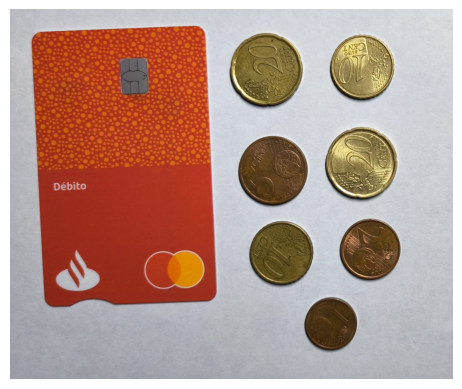

In [8]:
#Carga imagen ejemplo con monedas
img = cv2.imread('Monedas_tarjeta1.jpg') 
print(img.shape)
#Recordar que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_rgb) 
plt.show()

87.45714569091797
Ángulo de rotación: 357.45714569091797 grados


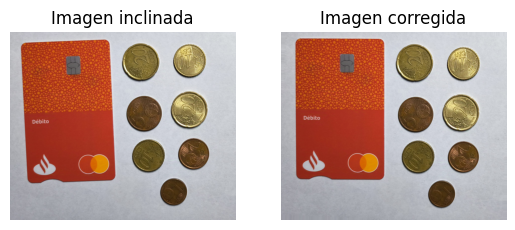

In [9]:

# Convertir a escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Aplicar un umbral para obtener una imagen binaria
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# Encontrar contornos en la imagen
contornos, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Encontrar el contorno más grande (asumiendo que es el objeto principal)
c = max(contornos, key=cv2.contourArea)

# Obtener el rectángulo de área mínima que encierra el contorno
rect = cv2.minAreaRect(c)

# Obtener el ángulo del rectángulo
angulo = rect[-1]
print(angulo)
# Ajustar el ángulo
if angulo < -45:
    angulo = +(90 - angulo)
else:
    angulo = 270 + angulo

print(f"Ángulo de rotación: {angulo} grados")

# Obtener el centro de la imagen y crear la matriz de rotación
(h, w) = img.shape[:2]
centro = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(centro, angulo, 1.0)

# Aplicar la rotación
img_rotada = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

# Mostrar la imagen original e imagen corregida
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Imagen inclinada")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_rotada, cv2.COLOR_BGR2RGB))
plt.title("Imagen corregida")
plt.axis("off")
img = img_rotada
plt.show()

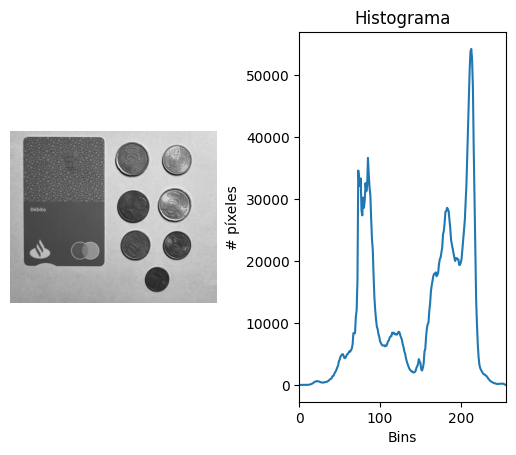

In [10]:
#Convierte la imagen a todos de gris, mostrando el resultado
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Cálculo del histograma con 256 bins de una imagen en escala de grises
hist = cv2.calcHist([img_gris], [0], None, [256], [0, 256])

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img_gris, cmap='gray')

# Histograma sin normalizar
plt.subplot(1, 2, 2)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("# píxeles")
plt.plot(hist)
plt.xlim([0, 256])
# Separo subplots horizontalmente
plt.subplots_adjust(wspace=0.4)

Umbral fijo usado  170.0
Umbral Otsu  140.0


Text(0.5, 1.0, 'OTSU invertida')

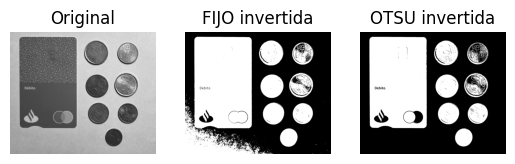

In [11]:
#Dos variantes de umbralizado. Probar otros parámetros, aplicar filtro previo, etc.
umbral = 170 # Prueba varios comenzando en 130
# Umbralizado binario invertido, dado que por defecto se asume objetos en blanco
th1,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
print('Umbral fijo usado ', th1)
# Umbralizado con método de Otsu para selección automática del umbral
th2,img_th2 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral Otsu ', th2)



plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')

Largo de la referencia: 1134.00 píxeles
Ancho de la referencia: 713.00 píxeles


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


23.009176
19.899826
21.79577
19.717817
22.341805
15.986599
18.504414
Dinero total: 0.68 €
Número de monedas: 7


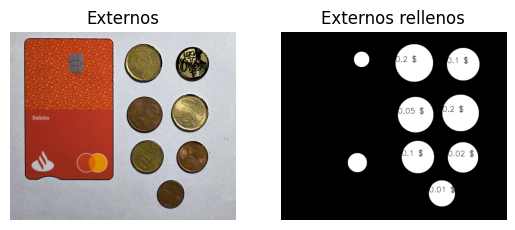

In [12]:
#Localiza contornos en imagen obtenida con umbral fijo
#findContours está diseñada para imágenes con  figura en blanco y fondo negro
#La imagen de entrada debe ser de un canal y 8 bits excepto en los modos RETR_CCOMP o RETR_FLOODFILL
#hierarchy contiene información sobre el nivel del contorno, relaciones paterno-filiales (contornos contenidos en otros)
monedas_euro = {
    "0.01": 16.25,
    "0.02": 18.75,
    "0.05": 21.25,
    "0.1": 19.75,
    "0.2": 22.25,
    "0.5": 24.25,
    "1": 23.25,
    "2": 25.75
}
#Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_th2, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

#Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,0,0), 3)

plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Externos')

#Dibuja contornos externos rellenos en imagen vacía
#Imagen negra
img_cont = np.zeros(img_rgb.shape)
#Recorre los contornos externos
for c in contornos2:
    #Área del contorno
    area = cv2.contourArea(c)
    if area > 500:
        # Dibujar los contornos detectados en una copia de la imagen original
        c = c
# Ajustar un rectángulo de área mínima al contorno de la regla
rect = cv2.minAreaRect(c)
box = cv2.boxPoints(rect)
box = np.int32(box)

# Obtener el tamaño del rectángulo (ancho y largo)
ancho = min(rect[1])
largo = max(rect[1])
largo_mm = 86
print(f"Largo de la referencia: {largo:.2f} píxeles")
print(f"Ancho de la referencia: {ancho:.2f} píxeles")
numero_de_monedas = 0
dinero_total = 0


# Convierte la imagen a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Conversión a gris
gris = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

# Suaviza altas frecuencias
pimg = cv2.medianBlur(gris, 9)

# Localiza Círculos
circ = cv2.HoughCircles(
    pimg,  # imagen
    cv2.HOUGH_GRADIENT,  # tipo de detección
    1, 100,  # distancia mínima entre círculos
    param1=90,  # Valor del gradiente
    param2=65,  # Umbral acumulador
    minRadius=10,  # radio mínimo
    maxRadius=200,  # radio máximo
)

for c in circ[0]:
    x_coor, y_coor, det_radio = c
    if det_radio > 10:
        
        # Calcular el diámetro en píxeles
        diametro_pixeles = 2 * det_radio
        # Calcular el diámetro en milímetros utilizando la tarjeta de referencia
        diametro_mm = largo_mm * (diametro_pixeles / largo)
        cv2.circle(img_rgb, (int(x_coor), int(y_coor)), int(det_radio), (0,0,0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)), int(det_radio),(255, 255, 255), -1)
        
        # Comparar con los diámetros conocidos de las monedas
        for moneda, diametro_real_mm in monedas_euro.items():
            if abs(diametro_mm - diametro_real_mm) < 0.8:  # Tolerancia de 0.8 mm
                numero_de_monedas += 1
                dinero_total += float(moneda)
                cv2.putText(img_cont, f'{moneda} $', (int(x_coor - det_radio), int(y_coor - 10)),
                            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)
                break  # Si se encuentra una coincidencia, no continuar buscando

# Mostrar los resultados finales
print(f'Dinero total: {dinero_total:.2f} €')
print(f'Número de monedas: {numero_de_monedas}')

                
                
plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()

Largo de la referencia: 1134.00 píxeles
Ancho de la referencia: 713.00 píxeles
21.462086
19.899826
19.717817
22.49348
22.159794
15.986599
18.504414
Dinero total: 0.68 €
Número de monedas: 7
Monedas encontradas = 7


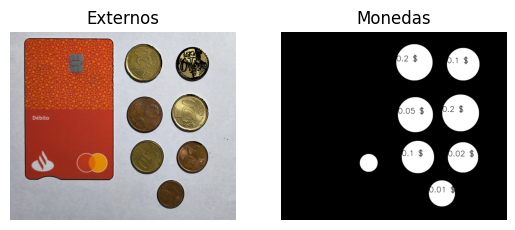

Moneda seleccionada: 0.2 EUR en (1071, 251)


In [13]:
#Localiza contornos en imagen obtenida con umbral fijo
#findContours está diseñada para imágenes con  figura en blanco y fondo negro
#La imagen de entrada debe ser de un canal y 8 bits excepto en los modos RETR_CCOMP o RETR_FLOODFILL
#hierarchy contiene información sobre el nivel del contorno, relaciones paterno-filiales (contornos contenidos en otros)
monedas_euro = {
    "0.01": 16.25,
    "0.02": 18.75,
    "0.05": 21.25,
    "0.1": 19.75,
    "0.2": 22.25,
    "0.5": 24.25,
    "1": 23.25,
    "2": 25.75
}
#Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_th2, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

#Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,0,0), 3)

plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Externos')

#Dibuja contornos externos rellenos en imagen vacía
#Imagen negra
img_cont = np.zeros(img_rgb.shape)
#Recorre los contornos externos
for c in contornos2:
    #Área del contorno
    area = cv2.contourArea(c)
    if area > 500:
        # Dibujar los contornos detectados en una copia de la imagen original
        c = c
# Ajustar un rectángulo de área mínima al contorno de la regla
rect = cv2.minAreaRect(c)
box = cv2.boxPoints(rect)
box = np.int32(box)

# Obtener el tamaño del rectángulo (ancho y largo)
ancho = min(rect[1])
largo = max(rect[1])
largo_mm = 86
print(f"Largo de la referencia: {largo:.2f} píxeles")
print(f"Ancho de la referencia: {ancho:.2f} píxeles")
numero_de_monedas = 0
dinero_total = 0

# Carga la imagen
#img = cv2.imread('Monedas_superpuestas2.jpg')
#print(img.shape)

# Convierte la imagen a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Conversión a gris
gris = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

# Suaviza altas frecuencias
pimg = cv2.medianBlur(gris, 9)

# Localiza Círculos
circ = cv2.HoughCircles(
    pimg,  # imagen
    cv2.HOUGH_GRADIENT,  # tipo de detección
    1, 100,  # distancia mínima entre círculos
    param1=90,  # Valor del gradiente
    param2=65,  # Umbral acumulador
    minRadius=10,  # radio mínimo
    maxRadius=150,  # radio máximo
)
monedas = []


# Dibuja sobre la imagen de entrada
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_cont = np.zeros(img_rgb.shape, dtype=np.uint8)

# Procesa los contornos
for contorno in circ[0]:
    x_coor, y_coor, radio = contorno
    if radio > 10:
        
        # Calcular el diámetro en píxeles
        diametro_pixeles = 2 * radio
        # Calcular el diámetro en milímetros utilizando la tarjeta de referencia
        diametro_mm = largo_mm * (diametro_pixeles / largo)
        cv2.circle(img_rgb, (int(x_coor), int(y_coor)), int(radio), (0,0,0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)), int(radio),(255, 255, 255), -1)
        
        # Comparar con los diámetros conocidos de las monedas
        for moneda, diametro_real_mm in monedas_euro.items():
            if abs(diametro_mm - diametro_real_mm) < 0.8:  # Tolerancia de 0.8 mm
                print(diametro_mm)
                numero_de_monedas += 1
                dinero_total += float(moneda)
                cv2.putText(img_cont, f'{moneda} $', (int(x_coor - radio), int(y_coor - 10)),
                            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)
                monedas.append((int(x_coor), int(y_coor), moneda, radio))
                break  # Si se encuentra una coincidencia, no continuar buscando

# Mostrar los resultados finales
print(f'Dinero total: {dinero_total:.2f} €')
print(f'Número de monedas: {numero_de_monedas}')

        
# Función para manejar eventos de clic del ratón
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # Busca si hay alguna moneda cerca de las coordenadas del clic
        for monedax in monedas:
            mx, my, valor, radio = monedax
            distancia = np.sqrt((x - mx)**2 + (y - my)**2)

            if distancia <= radio:
                print(f"Moneda seleccionada: {valor} EUR en ({mx}, {my})")
                break


plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont)
plt.title('Monedas')

print("Monedas encontradas = " + str(numero_de_monedas))
plt.show()

# Configura el tamaño de la ventana de visualización
cv2.namedWindow('Image', cv2.WINDOW_NORMAL)

# Cambia el tamaño de la ventana
window_width = 800  # Ancho de la ventana
window_height = 600  # Alto de la ventana
cv2.resizeWindow('Image', window_width, window_height)

# Configura el manejador de eventos de clic del ratón
cv2.setMouseCallback('Image', mouse_callback)

# Muestra la imagen
cv2.imshow('Image', img_rgb)

while True:
    key = cv2.waitKey(1)

    if key == 27:  # Presiona la tecla 'Esc' para salir
        break

cv2.destroyAllWindows()


TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Accuracy: 0.72
Precision: 0.76
Recall: 0.74
F1 Score: 0.75


Text(50.722222222222214, 0.5, 'Real/Anotado')

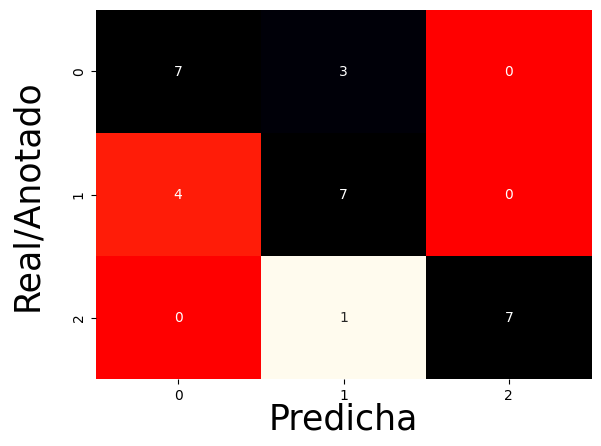

In [14]:
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png')

# Funcion encargada de filtrar los contornos obtenidos de las imagenes.
def filtrar_contorno(img, umbral, limite_superior):

    # Pasamos la imagen a gris
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Le aplicamos umbralizado binario invertido, bastante util para fondos blancos.
    res,img_th1 = cv2.threshold(gray,umbral,255,cv2.THRESH_BINARY_INV)

    # Obtenemos unicamente los contornos externos
    contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

    # Filtramos de los contornos obtenidos y unicamente obtenemos aquellos que superen las condiciones
    lista_contornos = [contour for contour in contornos2 if (cv2.contourArea(contour) >= 500 and cv2.contourArea(contour) <= limite_superior)]
    
    # Retornamos finalmente la lista de contornos
    return lista_contornos

# Contornos obtenido de las 3 imagenes (Fragmentos, Alquitran y Pellet)
contornos_fragmentos = filtrar_contorno(imgF,130,100000)
contornos_alquitran = filtrar_contorno(imgT,100,40000)
contornos_pellet = filtrar_contorno(imgP,110,500000)

# Clasificador de Alquitran
def tar_classifier(list_contornos, imagen_gris):

    # Umbral para distinguir colores oscuros y relación de aspecto aceptable
    umbral_color_oscuro = 70
    umbral_relacion_aspecto = 0.9
    predicciones = []

    # Iterar sobre los contornos detectados
    for contorno in list_contornos:

        # Calcular las dimensiones del contorno
        x, y, w, h = cv2.boundingRect(contorno)
        relacion_aspecto = float(w) / h # Relación ancho/alto

        # Calcular el perímetro y área del contorno para determinar compacidad
        perimetro = cv2.arcLength(contorno, True)
        area = cv2.contourArea(contorno)
        compacidad = (4 * math.pi * area) / (perimetro ** 2)

        # Extraer la región del contorno en la imagen en escala de grises
        region_contorno = imagen_gris[y:y+h, x:x+w]
        promedio = np.mean(region_contorno) # Promedio de intensidad de píxeles

        # Clasificar como 'Tar' si cumple con la relación de aspecto, compacidad y color oscuro
        if (1 - umbral_relacion_aspecto <= relacion_aspecto <= 1 + umbral_relacion_aspecto) and compacidad <= 0.8 and promedio < umbral_color_oscuro:
            predicciones.append('Tar')
        else:
            # Si no cumple las condiciones, se clasifica como 'Pellet' (clase más probable)
            predicciones.append('Pellet')

    # Devolver las predicciones
    return predicciones

# Clasificador de Fragmentos
def fragment_classifier(list_contornos, imagen_gris):
    umbral_color_oscuro = 70
    umbral_relacion_aspecto = 0.9
    predicciones = []

    for contorno in list_contornos:
        x, y, w, h = cv2.boundingRect(contorno)
        relacion_aspecto = float(w) / h
        perimetro = cv2.arcLength(contorno, True)
        area = cv2.contourArea(contorno)
        compacidad = (4 * math.pi * area) / (perimetro ** 2)

        region_contorno = imagen_gris[y:y+h, x:x+w]
        promedio = np.mean(region_contorno)

        # Condiciones para clasificar como 'Fragment'
        if (1 - umbral_relacion_aspecto <= relacion_aspecto <= 2 + umbral_relacion_aspecto) and compacidad < 0.6 and promedio > umbral_color_oscuro:
            predicciones.append('Fragment')
        else:
            # Si no cumple con las condiciones estrictas, devolvemos la clase más probable
            predicciones.append('Pellet')

    return predicciones

# Clasificador de Pellet
def pellet_classifier(list_contornos, imagen_gris):
    umbral_color_oscuro = 70
    umbral_relacion_aspecto = 0.2
    predicciones = []

    for contorno in list_contornos:
        x, y, w, h = cv2.boundingRect(contorno)
        relacion_aspecto = float(w) / h
        perimetro = cv2.arcLength(contorno, True)
        area = cv2.contourArea(contorno)
        compacidad = (4 * math.pi * area) / (perimetro ** 2)

        region_contorno = imagen_gris[y:y+h, x:x+w]
        promedio = np.mean(region_contorno)

        # Condiciones para clasificar como 'Pellet'
        if (1 - umbral_relacion_aspecto <= relacion_aspecto <= 1 + umbral_relacion_aspecto) and compacidad > 0.6 and promedio > umbral_color_oscuro:
            predicciones.append('Pellet')
        else:
            # Si no cumple con las condiciones estrictas, devolvemos la clase más probable
            predicciones.append('Fragment')

    return predicciones


# Etiquetas verdaderas para cada grupo
y_true_F = ['Fragment'] * len(contornos_fragmentos)
y_true_P = ['Pellet'] * len(contornos_pellet)
y_true_T = ['Tar'] * len(contornos_alquitran)

# Obtén las predicciones para cada clasificador
y_pred_F = fragment_classifier(contornos_fragmentos,cv2.cvtColor(imgF, cv2.COLOR_BGR2GRAY))
y_pred_P = pellet_classifier(contornos_pellet, cv2.cvtColor(imgP, cv2.COLOR_BGR2GRAY))
y_pred_T = tar_classifier(contornos_alquitran, cv2.cvtColor(imgT, cv2.COLOR_BGR2GRAY))

# Unimos etiquetas verdaderas y predichas
y_true = y_true_F + y_true_P + y_true_T
y_pred = y_pred_F + y_pred_P + y_pred_T

# Calculamos la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred, labels=['Fragment', 'Pellet', 'Tar'])
print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.2f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.2f}")
print(f"F1 Score: {f1_score(y_true, y_pred, average='macro'):.2f}")

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)